# Thermal evolution
In this chapter, you will learn how to use MOAI to calculate the time-evolution of magma ocean crystallization, by resolving the heat conservation equation. Don't grab your pen and paper yet, MOAI takes care of solving the equation, you just have to give it the right inputs!

In [1]:
import numpy as np
from physics.constants import Earth_gravity,Earth_surface_radius
from magma_ocean import magma_ocean
from physics.eos import eos_book
MO = magma_ocean(3000,
                 135e9,
                 eos={'rho':eos_book['rho']['MK19l'],'alpha':eos_book['alpha']['N19'],'cp':eos_book['cp']['cst']},         
                 g=Earth_gravity,
                 R=Earth_surface_radius,
                 ConvCum=True)

## Calculate the planetary heat flux

### Boundary layer
The convective heat flux in the MO is calculated using boundary layer theory. According to boundary layer theory, this heat flux is:   
$$F_{\rm conv}=a\frac{k\Delta T}{d}{\rm Ra}^b,$$
where $a$ and $b$ are constants depending on the chosen scaling, $k$ is the thermal conductivity, $\Delta T$ is the temperature drop accross the thermal boundary layer, $d$ is the MO depth, and ${\rm Ra}$ is the Rayleigh number, defined as:   
$${\rm Ra}=\frac{\alpha\rho\Delta Tgd^3}{\kappa\eta},$$       
where $\alpha$ is the thermal expansivity, $\rho$ the density, $g$ the gravity, $\kappa=\rho c_pk$ the thermal diffusivity ($c_p$ being the heat capacity) and $\eta$ the viscosity. The only quantities that we miss to calculate the heat flux are $k$, $\eta$ and $\Delta T$. We need tp precise the value (or parametrizations) for the first two, and $\Delta T$ is $T_{\rm pot}-T_{\rm sfc}$, where $T_{\rm pot}$ is the MO potential temperature (that we know), and $T_{\rm sfc}$ is the only remaining unknown!   

In [2]:
# We set the viscosity equal to 0.1 Pa s
MO.setParametrization('viscosity',lambda var: 0.1*np.ones(MO.N),[])

# And the thermal conductivity equal to 4 W/K/m
MO.setParametrization('k',lambda var: 4.*np.ones(MO.N),[])

# And finally we create the boundary layer object, which will take care of calculating the flux
# provided the temperature drop (initialized to 1 here, but it is not used and will be overwritten)
MO.addBoundaryLayer(1.)

### Black-body atmosphere
But why do we need an unknown? Because we need to know the forcing which is driving convection, and this is provided by the equation for which $T_{\rm sfc}$ is the unknown. This equatoin is the equality between the convective flux out of the MO and the flux radiated at the surface of the planet:     
$$F_{\rm conv}(T_{\rm sfc})=OLR(T_{\rm sfc})-ASR,$$
where ${\rm OLR}$ stands for Outgoing Longwave Radiation, i.e. the infrared flux emitted by the surface, and ${\rm ASR}$ for Arriving Shortwave Radiation, i.e. the insolation. The latter is a simple function of the solar flux and the orbital distance (generally condensed in the equilibrium temperature of the planet). The former can be very complicated to calculate, depending on the sort of atmosphere that you consider. Her for simplicity, we only consider black body radiation of the surface, as if there was no atmosphere at all.

In [3]:
# First create a (black-body) atmosphere object
from atmospheres import black_body
MO.atm = black_body([],                 # that's for the molecular species present in the atmosphere: here, nothing
                    [],                 # that's the partial pressure to initialize the molecules: again, nothing
                    MO.adiabat.T_pot-1, # that's T_sfc. To be consistent with our initialization of delta T in the boundary layer (but it is not used and will be overwritten)
                    g=MO.gravity,       # gravity (consistent with the MO value)
                    R=MO.R_out)         # surface radius (consistent with the MO value)

The resolution of Equation (1) is done by finding the root to the "flux_residual" function:

In [4]:
# Planetary heat flux
def flux_residual(MO,T_sfc):
    MO.updateBL(T_sfc)     # calculates the Ra and F_conv for T_sfc
    MO.atm.updateTs(T_sfc) # set atmosphere surface temperature to T_sfc
    return MO.BL.getFlux()-(MO.atm.getOLR()-MO.atm.getASR()) # Eq. (1)

We can now calculate the planetary heat flux:

In [5]:
from scipy.optimize import root_scalar
T_sfc = root_scalar(lambda T:flux_residual(MO,T),
                    method='brentq',
                    x0=MO.adiabat.T_pot-1.,       # initial guess
                    bracket=[MO.atm.T_eq,         # T_sfc cannot be smaller than the equilibrium temperature, otherwise F_conv would be negative!
                             MO.adiabat.T_pot], # T_sfc cannot be higher than T_pot, otherwise F_conv would be negative too!
                    xtol=0.1).root
# No need to update the atmosphere with T_sfc, it has been done each time
# flux_residual was called, so the last call was with the converged value of T_sfc
print('T_sfc=',T_sfc,'K, OLR=',MO.atm.getOLR(),'W/m²')

T_sfc= 1918.6533109915713 K, OLR= 768338.3224615065 W/m²


## Thermal evolution of the MO

Now that we can calculate the heat flux, we may want to use it to know the time-evolution of the MO thermal state. To begin with, let's forget about crystallization, and look at the cooling of the MO while it is still completely molten. The simplest form of the heat conservation equation in this case is:    
$$\frac{dE_{\rm th}}{dt}=-4\pi R_p^2F_{\rm conv},$$ 
where $E_{\rm th}$ is the thermal energy in the MO, $t$ is the time, and $R_p$ is the planetary radius. Here we have neglected heat flow from the core and internal heating. We can further simplify and write the left-hand-side term (the secular cooling) as:   
$$\frac{dE_{\rm th}}{dt}=\frac{dE_{\rm th}}{dtT_{\rm pot}}\times\frac{dT_{\rm pot}}{dt},$$
and consider $\frac{dE_{\rm th}}{dtT_{\rm pot}}$ as a constant, whose value is approximately $8\times10^{27}$ J/K.    
We can then recast Eq. 2 as an evolution equation for $T_{\rm pot}$. The magma_ocean class has a built in method (RK4_step) to solve this equation, using a Runge-Kutta 4$^{\rm th}$ order stepping.

In [6]:
# First, we add flux_residual as an attribute of MO because it will be called automatically by the Runge-Kuta 4th-order time stepper
MO.flux_residual = flux_residual

# Then, we also add dEth_dTpot
MO.dEth_dTpot = 8e27 # [J/K]

# Finally, we call the Runge-Kutta stepper, firt for a timestep zero
MO.RK4_step(0)

# Let's see
print('T_pot=',MO.adiabat.T_pot,'K, T_sfc=',MO.atm.Ts,'K, OLR=',MO.atm.getOLR(),'W/m²')

T_pot= 3000.0 K, T_sfc= 1918.6526960291235 K, OLR= 768417.4339313044 W/m²


Of course, nothing happened since the timestep was zero. Now let's have a look at a non-zero time-step:

In [7]:
from utils import y2s
dt = y2s # [s]
MO.RK4_step(dt)

# Let's see now
print('T_pot=',MO.adiabat.T_pot,'K, T_sfc=',MO.atm.Ts,'K, OLR=',MO.atm.getOLR(),'W/m²')

T_pot= 2998.456376564973 K, T_sfc= 1918.0790330259056 K, OLR= 767498.8414344074 W/m²


The MO has cooled down by more than 1.5 K over one year. Let's see how long it will take to reach the liquidus

In [8]:
cooling_time = 0

from physics.phase_change.refractories import mc_book
while min(mc_book['Earth'].getMeltFraction(MO.profiles['pressures'],MO.profiles['temperatures']))==1:
    MO.RK4_step(dt)
    cooling_time += dt

# Let's see now
print('T_pot=',MO.adiabat.T_pot,'K, T_sfc=',MO.atm.Ts,'K, OLR=',MO.atm.getOLR(),'W/m²')
print('cooling time:',cooling_time/y2s,' yr')

T_pot= 2993.836566012027 K, T_sfc= 1916.3608650892058 K, OLR= 764752.5081322601 W/m²
cooling time: 3.0  yr


That was not too far! For further cooling, we need to take into consideration the latent heat release associated with crystallization. The heat conservatoin equation becomes:   $$\frac{dE_{\rm th}}{dt}=4\pi R_p^2F_{\rm conv}+L\frac{dM_{\rm sol}}{dt},$$
where $L$ is the latent heat of crystallization and $M_{\rm sol}$ is the mass of crystals. Adding the latent heat term to the equation in the RK4_step function is done automatically when we add melting curves to our magma ocean (which will also calculate its depth). Notice that we could have done it since the beginning, the latent heat term would just have been zero as long as the temperature is super solidus everywhere in the mantle.

In [9]:
MO.setMeltingCurves(mc_book['Earth'],RCMF=0.4)

No file found: calculating lookups, be patient it can take some time!


Let's now see how long it takes our magma ocean to fully solidify

In [10]:
# We canuse a time_series object to record the evolution of some quantities of interest
from tools import time_series
ts = time_series(MO)
ts.register('OLR','atm.getOLR()')
ts.write(0)

crytallization_time = 0

# Let's consider the MO fully solidified when its depth is less the 1 GPa
while MO.p_bot>1e9:
    MO.RK4_step(dt)
    crytallization_time += dt
    ts.write(crytallization_time)

# Let's see now
print('T_pot=',MO.adiabat.T_pot,'K, T_sfc=',MO.atm.Ts,'K, OLR=',MO.atm.getOLR(),'W/m²')
print('crystallization time:',crytallization_time/y2s,' yr')

T_pot= 1564.0630445970378 K, T_sfc= 1261.8251032825683 K, OLR= 143750.1774272231 W/m²
crystallization time: 2371.0  yr


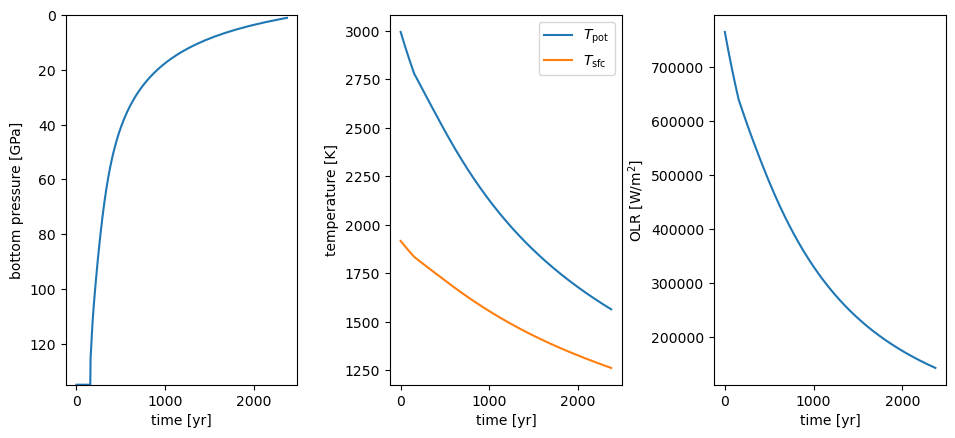

In [18]:
import matplotlib.pyplot as plt

plt.subplot(131)
plt.plot(ts('time')/y2s,ts('p_bot')*1e-9)
plt.ylim(135,0)
plt.xlabel('time [yr]')
plt.ylabel('bottom pressure [GPa]')

plt.subplot(132)
plt.plot(ts('time')/y2s,ts('T_pot'),label=r'$T_{\rm pot}$')
plt.plot(ts('time')/y2s,ts('T_sfc'),label=r'$T_{\rm sfc}$')
plt.legend()
plt.xlabel('time [yr]')
plt.ylabel('temperature [K]')

plt.subplot(133)
plt.plot(ts('time')/y2s,ts('OLR'))
plt.xlabel('time [yr]')
plt.ylabel(r'OLR [W/m$^2$]')

plt.subplots_adjust(right=1.5,wspace=0.4)